In [1]:
import tempfile
import urllib.request

import sys
sys.path.append("../")

import pandas as pd
import joblib

%matplotlib inline
import matplotlib.pyplot as plt

import transformers as tr #custom ad-hoc classes for pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

## Reading and preparing stratified sample
from [notebook](https://github.com/woldemarg/ds_tests/blob/master/machine_learning/company_3/task_solution/scripts/notebooks/get_sample.ipynb)

In [2]:
sample = (pd.read_csv("https://raw.githubusercontent.com/woldemarg/ds_tests/master/machine_learning/company_3/task_solution/derived/sample.csv")
          .drop(["id"], axis=1))

In [3]:
cat_cols = sample.columns[sample.columns.str.startswith("cat")]
sample.loc[:, cat_cols] = sample[cat_cols].astype(str)

In [4]:
y_sample = sample["gb"]
X_sample = sample.copy()

## Reading base pipeline
from [notebook](https://github.com/woldemarg/ds_tests/blob/master/machine_learning/company_3/task_solution/scripts/notebooks/model_pipeline.ipynb)

In [5]:
temp_dir_path = tempfile.mkstemp()
file_path = (urllib
             .request
             .urlretrieve("https://github.com/woldemarg/ds_tests/raw/master/machine_learning/company_3/task_solution/derived/model_pipe.sav",
                          temp_dir_path[1]))

model_pipe = joblib.load(file_path[0])

## Implementing illustrative grid search with pipeline
pipeline from [notebook](https://github.com/woldemarg/ds_tests/blob/master/machine_learning/company_3/task_solution/scripts/notebooks/model_pipeline.ipynb)

In [6]:
param_grid = {"xgb_model__n_estimators": [500, 750, 1000],
              "xgb_model__learning_rate": [0.001, 0.01, 0.1]}

search_cv = GridSearchCV(model_pipe,
                         param_grid=param_grid,
                         scoring="roc_auc",
                         n_jobs=-1)

search_cv.fit(X_sample, y_sample)

print("Best ROC-AUC on CV: {}:".format(search_cv.best_score_))
print(search_cv.best_params_)

Best ROC-AUC on CV: 0.9143318376113612:
{'xgb_model__learning_rate': 0.1, 'xgb_model__n_estimators': 1000}


In [7]:
model_pipe.set_params(xgb_model__n_estimators=1000,
                      xgb_model__learning_rate=0.1)

Pipeline(memory=None,
         steps=[('f_selection',
                 Pipeline(memory=None,
                          steps=[('drop_initial',
                                  <transformers.DropColumnsTransformer object at 0x000001BFDDE81B48>),
                                 ('impute_cats',
                                  <transformers.CustomImputer object at 0x000001BFDDE81788>),
                                 ('impute_nums',
                                  <transformers.CustomImputer object at 0x000001BFDDE81E48>),
                                 ('encode_oh',
                                  <transformers.CustomOHEncoder object at 0x0000...
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               n_estimators=1000, n_jobs=-1,

Hmm... Pretty close to defaults with *the bigger, the better*-logic as to the number of estimators! It seems like we ended up with a mild rise in ROC-AUC score: **0,91**.  

## Drawing learning curves

(0.8, 1.05)

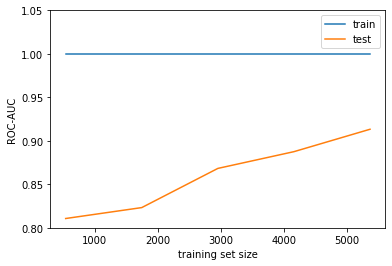

In [8]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model_pipe,
    X=X_sample,
    y=y_sample,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=1234)

train_scores_mean = train_scores.mean(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)

plt.plot(train_sizes,
         train_scores_mean,
         label="train")
plt.plot(train_sizes,
         validation_scores_mean,
         label="test")
plt.legend()
plt.xlabel("training set size")
plt.ylabel("ROC-AUC")
plt.ylim(0.8, 1.05)

# plt.savefig("machine_learning/company_3/task_solution/derived/model_learning_curve.png")

The plot suggests that validation (test) curve could converge towards the training curve if more training instances were added. Luckily we have them to train our model! - see [next notebook](https://github.com/woldemarg/ds_tests/blob/master/machine_learning/company_3/task_solution/scripts/notebooks/pipeline_predict.ipynb)


In [9]:
# joblib.dump(model_pipe, "machine_learning/company_3/task_solution/results/model_pipe_tuned.sav")